In [2]:
%matplotlib inline

In [3]:
%load_ext line_profiler

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from arc import Rubidium85, ShirleyMethod

In [6]:
atom = Rubidium85()
t = [56, 2, 2.5]

mj = 0.5
q = 0

In [7]:
m = ShirleyMethod(atom)
m.defineBasis(
    *t,
    mj,
    basisStates=[
        [56, 2, 2.5, 0.5],
        [57, 1, 1.5, 0.5]
    ],
    progressOutput=True,
    debugOutput=False,
)
m.defineShirleyHamiltonian(fn=1)

Generating matrix...
100%
Energies and Couplings Generated


In [254]:
Efield = 5 # V/m
f0 = 12.0073e9 # Hz

efields = np.geomspace(1e-4, 1, 10) * Efield
dets = np.linspace(-1e9, 1e9, 101)
freqs = dets + f0

In [260]:
m.diagonalise(Efield, freqs, progressOutput=True)

Finding eigenvectors...


In [249]:
print(m.indexOfCoupledState)

0


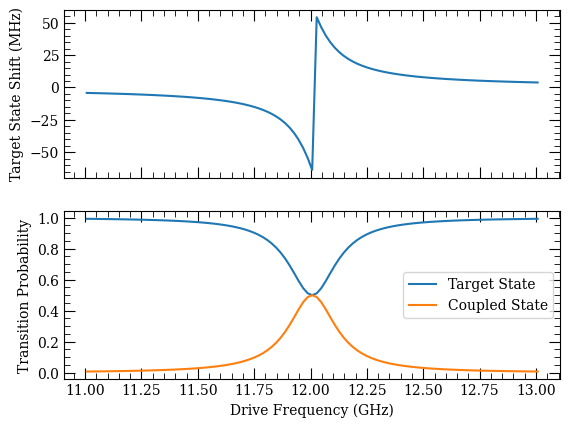

In [261]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(freqs*1e-9, m.targetShifts*1e-6)

ax2.plot(freqs*1e-9, m.transProbs[:,0], label='Target State')
ax2.plot(freqs*1e-9, m.transProbs[:,1], label='Coupled State')
ax1.set_ylabel('Target State Shift (MHz)')
ax2.set_ylabel('Transition Probability')
ax2.set_xlabel('Drive Frequency (GHz)')
ax2.legend();

Diagonalize a single point

In [450]:
m.diagonalise(Efield, f0-1e8, progressOutput=True)

Finding eigenvectors...


In [451]:
dim0 = len(m.basisStates)
dim1 = 2*m.fn + 1
refInd = m.fn * dim0
tarInd = m.indexOfCoupledState + refInd
print(refInd)
print(tarInd)
eigs = m.eigs.copy()
egvector = m.eigVectors.copy()

2
2


In [376]:
m1 = (np.abs(np.conj(egvector) * egvector[tarInd])**2)
print(m1.shape)
m2 = m1.reshape((2 * m.fn + 1, dim0, (2 * m.fn + 1) * dim0))
print(m2.shape)
m3 = m2.sum(axis=(0,-1))
print(m3)
print(m3.sum())

(6, 6)
(3, 2, 6)
[0.69149167 0.30850833]
1.0000000000000002


In [377]:
tau = 1/f0
print(f'Drive period: {tau*1e12:.3f} fs')
ts = np.linspace(0, 2*tau, 100)

Drive period: 83.283 fs


In [378]:
d2 = np.array([[1, 2],
               [3, 5]])
d1 = np.array([0.5, 2])
print(d2*d1)
print(np.einsum('mk,k->mk', d2, d1))

[[ 0.5  4. ]
 [ 1.5 10. ]]
[[ 0.5  4. ]
 [ 1.5 10. ]]


In [379]:
t1 = (np.conj(egvector)*egvector[tarInd])
t2 = np.einsum('mk,k->mk', np.conj(egvector), egvector[tarInd])
print(t2.shape)
np.allclose(t1, t2)

(6, 6)


True

In [380]:
t1 = (np.conj(egvector[None,:,:])*egvector[None,tarInd,:]*np.exp(-1.0j*2*np.pi*eigs[None,None,:]*ts[:,None,None])).sum(axis=-1)
t2 = np.einsum('lk,mk,k->lm',np.exp(-1.0j*2*np.pi*eigs[None,:]*ts[:,None]), np.conj(egvector), egvector[tarInd], )
print(t1.shape)
print(t2.shape)
np.allclose(t1, t2)

(100, 6)
(100, 6)


True

In [452]:
u1 = np.exp(-1.0j*2*np.pi*eigs[None,:]*ts[:,None])
print(u1.shape)
u2 = np.einsum('lm,km,m->lk',u1, np.conj(egvector), egvector[tarInd])
u3 = np.abs(u2)**2
print(u3.shape)
u4 = u3.reshape(u3.shape[:-1] + (dim1, dim0))
print(u4.shape)
u5 = u4.sum(axis=-2)
print(u5.shape)
print(np.mean(u5,axis=0))

(100, 6)
(100, 6)
(100, 3, 2)
(100, 2)
[0.99850609 0.00149391]


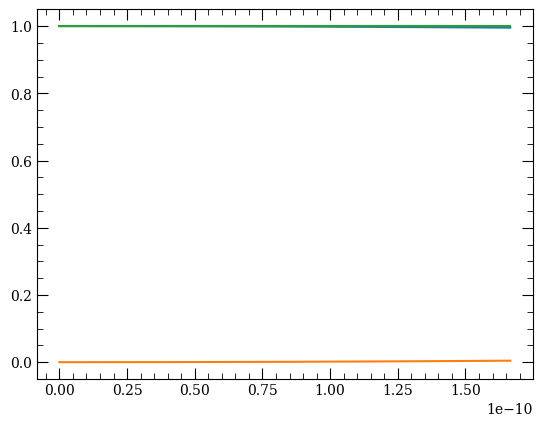

In [456]:
fig, ax = plt.subplots(1)

ax.plot(ts, u5)
ax.plot(ts, u5.sum(axis=-1))

Diagonalize the whole array

In [459]:
m.diagonalise(efields, freqs, progressOutput=True)

Finding eigenvectors...


In [460]:
tau = 1/f0
print(f'Drive period: {tau*1e12:.3f} fs')
ts = np.linspace(0, 2*tau, 100)

Drive period: 83.283 fs


In [461]:
dim0 = len(m.basisStates)
dim1 = 2*m.fn + 1
refInd = m.fn * dim0
tarInd = m.indexOfCoupledState + refInd
cInd = tarInd + 1
print(refInd, tarInd, cInd)

2 2 3


In [405]:
ut = np.exp(-1.0j*2*np.pi*np.einsum('...i,j->j...i', m.eigs, ts))
print(ut.shape)
print(m.eigVectors.shape)
print(m.eigVectors[...,tarInd,:].shape)

(4, 10, 101, 6)
(10, 101, 6, 6)
(10, 101, 6)


In [408]:
u2 = np.einsum('l...m,...km,...m->l...k',
                    ut,
                    np.conj(m.eigVectors),
                    m.eigVectors[...,tarInd,:]
                   )
print(u2.shape)

(4, 10, 101, 6)


In [409]:
us = u2[:,-1,51]
us2 = us.reshape(us.shape[:-1] + (dim1, dim0))
print(us2)
print(np.abs(us2))
print(np.abs(us2)**2)
print(np.sum(np.abs(us2)**2, axis=-2))

[[[ 1.20870502e-19+0.00000000e+00j -8.67361738e-19+0.00000000e+00j]
  [ 1.00000000e+00+0.00000000e+00j -1.32698200e-19+0.00000000e+00j]
  [-8.70127300e-17+0.00000000e+00j -5.55111512e-17+0.00000000e+00j]]

 [[ 3.30964925e-18+1.00778303e-18j  4.18630313e-03+1.87881612e-03j]
  [ 5.88053610e-01+8.08505072e-01j -1.46089945e-16+1.56191979e-16j]
  [-1.58559293e-14-7.03055672e-15j  1.78826425e-02-1.31017565e-02j]]

 [[ 3.85607290e-18-4.01917840e-18j -3.40737447e-03+3.02884405e-03j]
  [-3.07711275e-01+9.50435796e-01j  1.87456522e-16+1.04197212e-16j]
  [ 1.28427225e-14-1.18037052e-14j  4.22643529e-02+1.33607737e-02j]]

 [[-2.80739403e-18-8.51796404e-18j  2.22793336e-05+5.13146166e-05j]
  [-9.48471994e-01+3.09812541e-01j -4.36734589e-19-1.07182214e-18j]
  [ 1.28698359e-16+1.78465739e-16j  2.12923929e-02+6.29578917e-02j]]]
[[[1.20870502e-19 8.67361738e-19]
  [1.00000000e+00 1.32698200e-19]
  [8.70127300e-17 5.55111512e-17]]

 [[3.45968276e-18 4.58858191e-03]
  [9.99743717e-01 2.13864926e-16]
  [1

In [416]:
m.eigVectors.shape

(10, 101, 6, 6)

In [420]:
new_shape

(8, 101, 6, 6, 3, 2, 3, 2)

In [477]:
eVecs = m.eigVectors.reshape(m.eigVectors.shape[:-2] + (dim1,dim0,dim1,dim0))
m1 = np.einsum('...jkmn,...mn->...jkmn', eVecs.conj(),
               eVecs[...,m.fn,m.indexOfCoupledState,:,:])
print(m1.shape)
m2 = np.abs(m1)**2
m3 = m2.sum(axis=(-4,-2,-1))
print(m3.shape)

(10, 101, 3, 2, 3, 2)
(10, 101, 2)


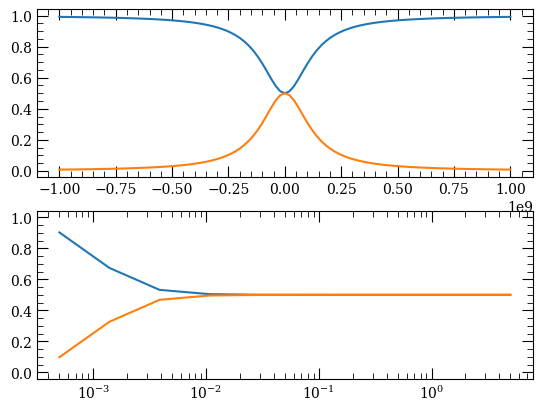

In [476]:
fig, (ax1, ax2) = plt.subplots(2,sharex=False,sharey=True)

ax1.plot(dets, m3[-1,:,:])

ax2.plot(efields, m3[:,50,:])
ax2.set_xscale('log')

In [ ]:
m1 = (np.abs(np.conj(egvector) * egvector[tarInd])**2)
print(m1.shape)
m2 = m1.reshape((2 * m.fn + 1, dim0, (2 * m.fn + 1) * dim0))
print(m2.shape)
m3 = m2.sum(axis=(0,-1))
print(m3)
print(m3.sum())

In [462]:
ti = 0
tki = 1
ci = 1
new_shape = m.eigVectors.shape[:-2] + (dim1, dim0) + (dim1,dim0)
eVecs = m.eigVectors.reshape(new_shape)
eVals = m.eigs.reshape(m.eigs.shape[:-1]+ (dim1, dim0))
print(eVecs.shape, eVals.shape)

ut = np.exp(-1.0j*2*np.pi*np.einsum('i,...->i...', ts, eVals))
print(ut.shape)

u2 = np.einsum('...kmn,j...mn,...mn->j...k',
          np.conj(eVecs[...,:,ci,:,:]),
          ut,
          eVecs[...,tki,ti,:,:])
print(u2.shape)
u3 = np.abs(u2)**2
operand = u3.sum(axis=-1)
print(operand.shape)
#u2 = np.einsum('...m,l...m,...m->l...',

(10, 101, 3, 2, 3, 2) (10, 101, 3, 2)
(100, 10, 101, 3, 2)
(100, 10, 101, 3)
(100, 10, 101)


Text(0.5, 0, 'Time ($\\tau$)')

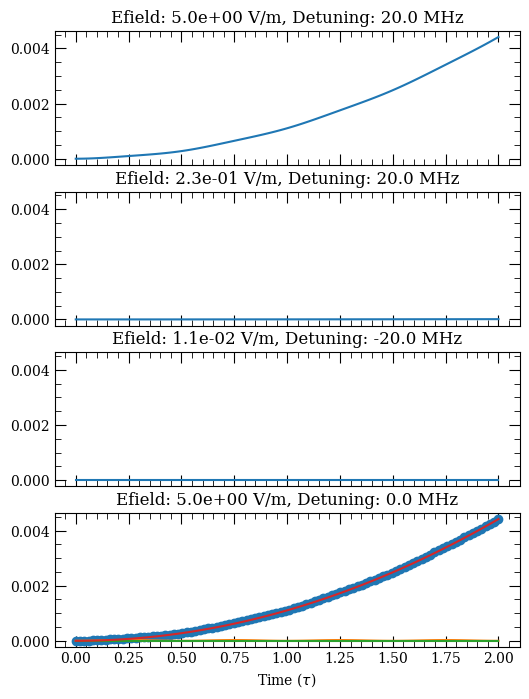

In [464]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, sharex=True, figsize=(6,8),sharey=True)

#ax1.set_ylim((0,1.1))
e = -1; f = 51;
ax1.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax1.plot(ts/tau, operand[:,e,f])

e = 6; f = 51;
ax2.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax2.plot(ts/tau, operand[:,e,f])

e = 3; f = 49;
ax3.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax3.plot(ts/tau, operand[:,e,f])

e = -1; f = 50;
ax4.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax4.plot(ts/tau, operand[:,e,f],'o-')
ax4.plot(ts/tau, u3[:,e,f])
ax4.set_xlabel('Time ($\\tau$)')

In [401]:
ut = np.exp(-1.0j*2*np.pi*np.einsum('...i,j->j...i', m.eigs, ts))
operand = (np.abs(np.einsum('...km,l...m,...m->l...k',
                    np.conj(m.eigVectors),
                    ut,
                    m.eigVectors[...,tarInd,:]
                   ))**2).reshape(ut.shape[:-1] + (dim1, dim0)
                            ).sum(axis=-2)
print(operand.shape)

(100, 10, 101, 2)


Text(0.5, 0, 'Time ($\\tau$)')

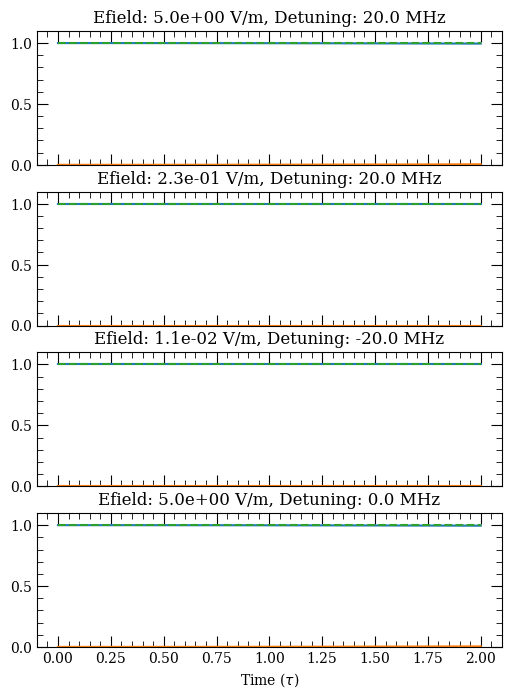

In [400]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, sharex=True, figsize=(6,8),sharey=True)

ax1.set_ylim((0,1.1))
e = -1; f = 51;
ax1.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax1.plot(ts/tau, operand[:,e,f,:])
ax1.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')

e = 6; f = 51;
ax2.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax2.plot(ts/tau, operand[:,e,f,:])
ax2.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')

e = 3; f = 49;
ax3.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax3.plot(ts/tau, operand[:,e,f,:])
ax3.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')

e = -1; f = 50;
ax4.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax4.plot(ts/tau, operand[:,e,f,:])
ax4.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')
ax4.set_xlabel('Time ($\\tau$)')